# Построение моделей для предсказания показателей регионов

## Описание работы

В данной работе предпринимается попытка создания моделей, позволяющих предсказывать:
* Контроль над ходом госзакупок (доля отмененных конкурсов в общем количестве), %;
* Общественное обсуждение законопроектов в Интернете (да - 1, нет - 0);
* Количество зарегистрированных организаций ТОС на 10 тысяч человек, штук.

Для предсказания используются следующие индикаторы:
* Институционные факторы:
    1. Конкурентность выборов (да - 1, нет - 0);
    2. Уровень парламентской конкуренции, %;
    3. Уровень конкуренции при формировании исполнительной власти, %;
    4. Включенность граждан в избирательный процесс, %;
    5. Участие граждан в деятельности общественных организаций, %;
* Инфраструктурные факторы:
    1. Количество абонентов сети интернет, тысяч;
    2. Количество абонентов мобильного интернета на 100 человек, единиц;
    3. Число персональных компьютеров на 100 человек, штук;
    4. Организации, связанные с бизнесом и использующие интернет (от общего числа обследованных организаций), %;
    5. Организации, связанные с бизнесом и имеющие веб-сайт (от общего числа обследованных организаций), %;
    6. Число персональных компьютеров на 100 работников в бизнесе, штук;
    7. Системы электронного документооборота (от общего числа обследованных организаций), %;
    8. Автоматический обмен данными между своими и внешними информационными системами (от общего числа обследованных организаций), %;
    9. Организации, имеющие отношение в органам власти и использующие интернет (от общего числа обследованных организаций), %;
    10. Доступность госуслуг, в том числе и за счет сокращения сроков предоставления (да - 1, нет - 0);
    11. Наличие инфраструктуры открытых данных, в том числе государственных (да - 1, нет - 0);
    12. Открытость процесса выборов (да - 1, нет - 0);
* Ресурсные факторы:
    1. Доля населения со средним образованием, %;
    2. Доля населения с высшим образованием, %;
    3. Доля населения, имеющего ученые степени, %;
    4. Доля специалистов в области ИКТ, %;
    5. ВРП на душу населения, рублей;
    6. Среднедушевые доходы населения, рублей;
    7. Объем использования программного обеспечения, %;
    8. Удельный вес инвестиций в основной капитал в ВВП, %;
    9. Доступность венчурного капитала, штук;
    10. Количество персональных компьютеров на 100 человек, штук;
    11. Затраты организаций на сетевые технологии, миллионов рублей; 
    12. Удельный вес затрат на ИКТ в ВРП, %.
    
Необходимо отметить, что в работе использовался достаточно скудный набор данных, из-за чего модели могут существенно отличаться при новом, более обширном анализе. С учетом этого, большинство шагов автоматизировано, что позволяет пересчитывать параметры моделей без внесения изменений в код.

## Код с комментариями

Импортируем используемые библиотеки.

In [95]:
import numpy as np
import pandas as pd
import seaborn as sb
from scipy import stats
from sklearn import preprocessing
from IPython.display import display
from sklearn.cross_validation import KFold
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline

Считываем данные из соответствующих файлов.

In [101]:
institutional_factors = pd.read_csv('institutional_factors.csv', index_col='index')
infrastructural_factors = pd.read_csv('infrastructural_factors.csv', index_col='index')
resource_factors = pd.read_csv('resource_factors.csv', index_col='index')
factors = [institutional_factors, infrastructural_factors, resource_factors]
targets = pd.read_csv('target.csv', index_col='index')

Изучаем таблицы.

In [104]:
print u'Институциональные факторы'
display(institutional_factors[:10])
print u'\nИнфраструктурные факторы'
display(infrastructural_factors[:10])
print u'\nРесурсные факторы'
display(resource_factors[:10])

Институциональные факторы


,elections,parliament,executive,citizens_election,citizens_org
index,,,,,
vo,1,47.98,36.15,63.8,1.67
ra,1,34.13,35.64,64.4,1.01
ao,1,44.02,43.74,56.2,0.83
rk,1,36.80,37.98,62.0,1.48
kk,1,27.40,29.16,70.8,1.10
ro,1,40.65,36.22,63.8,0.96



Инфраструктурные факторы


,internet_all,internet_mobile,internet_pc,org_access,org_site,org_pc,edm,edm_external,authority_access,public_services,open_data,open_election
index,,,,,,,,,,,,
vo,361.6,58.0,101.0,79.2,33.0,43.0,54.5,47.4,91.5,1,1,1
ra,27.8,70.8,104.0,96.2,51.0,45.0,82.1,44.6,98.3,1,1,1
ao,130.2,72.9,108.0,86.0,34.7,44.0,54.4,51.0,90.7,1,1,1
rk,24.0,66.6,89.0,89.4,28.5,49.0,59.8,51.6,89.6,1,1,1
kk,810.9,82.9,113.0,89.2,21.9,39.0,51.6,44.2,97.1,1,1,1
ro,608.3,57.9,105.0,86.0,34.6,43.0,53.1,43.5,97.9,1,1,1



Ресурсные факторы


,average_edu,high_edu,degree,ict,grp,income,po,invest,venture,pc,nt,ict_grp
index,,,,,,,,,,,,
vo,65.9,30.8,0.015,1.410,278961.2,19055.7,78.0,1.3,1,43,2252.6,5.580
ra,63.3,31.2,0.016,0.948,174017.6,22054.2,95.3,0.1,0,45,46.9,0.427
ao,62.4,32.0,0.028,1.320,283591.2,22168.8,82.3,0.8,0,44,213.6,1.003
rk,59.2,36.3,0.027,1.327,163688.1,12398.4,84.4,0.1,0,49,88.8,0.648
kk,68.7,28.3,0.031,1.080,330100.2,28787.8,83.8,5.1,1,39,12595.5,7.602
ro,63.7,31.3,0.035,1.739,235695.9,23354.7,82.4,1.9,0,43,657.6,0.753


Некоторые индикаторы принимают лишь одно значение на изучаемой выборке и бесполезны для построения модели. Удалим их.

In [ ]:
institutional_factors.d

In [120]:
cleared_factors = []
for df in factors:
    for column in df.columns:
        if df.min()[column] == df.max()[column]:
            df = df.drop(column, axis=1)
    cleared_factors.append(df)
for df in cleared_factors:
    print df

       parliament  executive  citizens_election  citizens_org
index                                                        
vo          47.98      36.15               63.8          1.67
ra          34.13      35.64               64.4          1.01
ao          44.02      43.74               56.2          0.83
rk          36.80      37.98               62.0          1.48
kk          27.40      29.16               70.8          1.10
ro          40.65      36.22               63.8          0.96
       internet_all  internet_mobile  internet_pc  org_access  org_site  \
index                                                                     
vo            361.6             58.0        101.0        79.2      33.0   
ra             27.8             70.8        104.0        96.2      51.0   
ao            130.2             72.9        108.0        86.0      34.7   
rk             24.0             66.6         89.0        89.4      28.5   
kk            810.9             82.9        113.0     

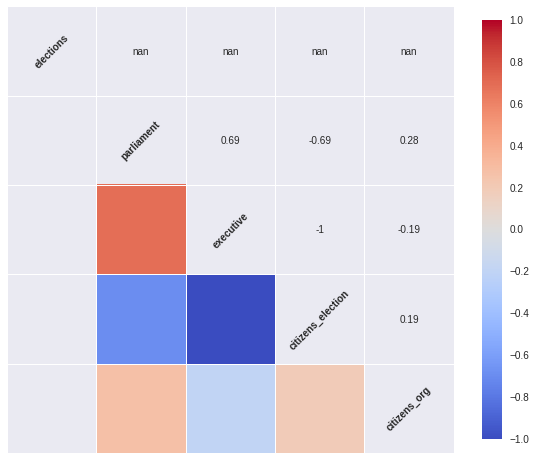

In [57]:
f, ax = plt.subplots(figsize=(10, 10))
sb.corrplot(institutional_factors)

In [65]:
infrastructural_factors

,internet_all,internet_mobile,internet_pc,org_access,org_site,org_pc,edm,edm_external,authority_access,public_services,open_data,open_election
index,,,,,,,,,,,,
vo,361.6,58.0,101.0,79.2,33.0,43.0,54.5,47.4,91.5,1,1,1
ra,27.8,70.8,104.0,96.2,51.0,45.0,82.1,44.6,98.3,1,1,1
ao,130.2,72.9,108.0,86.0,34.7,44.0,54.4,51.0,90.7,1,1,1
rk,24.0,66.6,89.0,89.4,28.5,49.0,59.8,51.6,89.6,1,1,1
kk,810.9,82.9,113.0,89.2,21.9,39.0,51.6,44.2,97.1,1,1,1
ro,608.3,57.9,105.0,86.0,34.6,43.0,53.1,43.5,97.9,1,1,1


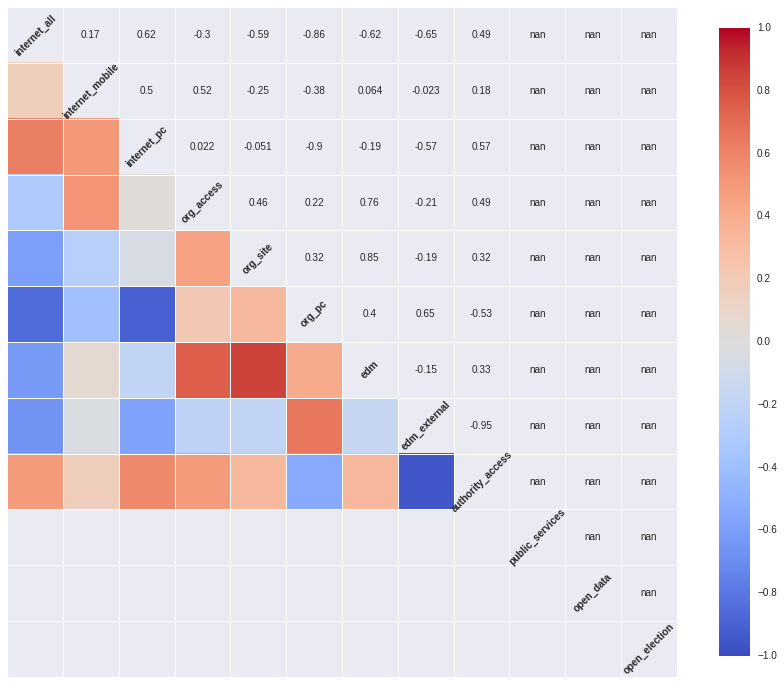

In [67]:
f, ax = plt.subplots(figsize=(15, 15))
sb.corrplot(infrastructural_factors)

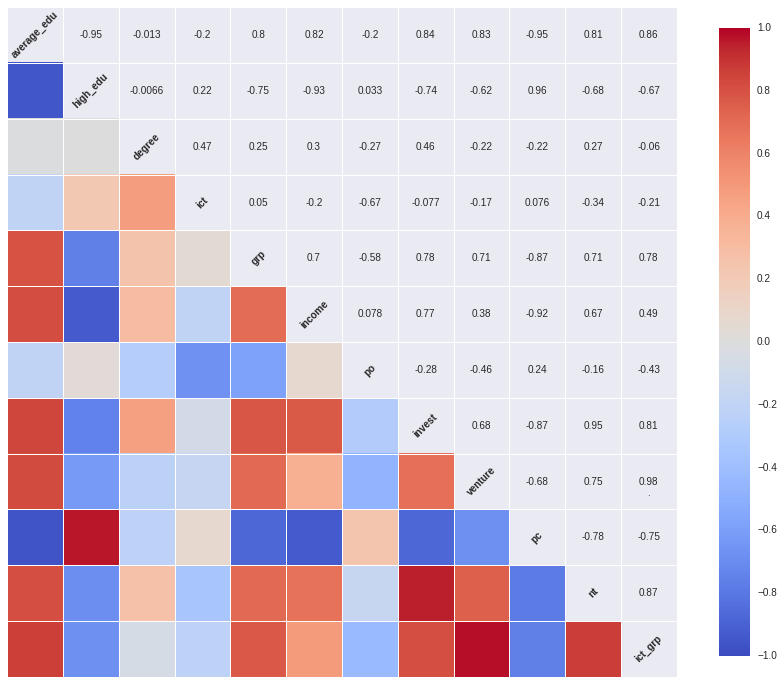

In [63]:
f, ax = plt.subplots(figsize=(15, 15))
sb.corrplot(resource_factors)